# Project prototype 1

### Your name
Write the name(s) of the author(s) of this assignment below:
* Brian Westerweel
* Christoph Schmidl
* Gijs van der Meijde
* Jeffrey Luppus

# First try in creating a project

### Notes:

* Copied notebook of **Assignment 8** as a starting point (working jupyter notebook).

## Imports

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob 
import random 
from tqdm import tqdm

# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Deep learning
import keras

# Other
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


## Data Download

## If the Jupter server runs on Cartesius

In [2]:
data_dir = '/projects/0/ismi2018/AMIDA13'

## If the Jupyter server runs on your computer

In [3]:
if False: #CHANGE THIS TO TRUE IF RUNNING ON OWN COMPUTER!
    import requests
    from tqdm import tqdm_notebook
    import zipfile

    link = 'https://surfdrive.surf.nl/files/index.php/s/1acVhUNggKyFLDk/download'
    file_name = "ismi-amida13.zip"
    with open(file_name, "wb") as f:
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')
            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                    dl += len(data)
                    f.write(data)
    with zipfile.ZipFile(file_name,"r") as zip_ref:
        zip_ref.extractall("./")
    os.remove('./ismi-amida13.zip')
    data_dir = './' # define here the directory where you have your data, downloaded from SURFDrive

### Always

In [4]:
# Create result dir
result_dir = './results' # define here the directory where your results will be saved
if not exists(result_dir):
    os.mkdir(result_dir)

## Data Preprocessing
Use the [Pandas](https://pandas.pydata.org/) dataframe to pre-process the data.

### Explore the Data

Investigate the input data: list paths to files, load images, plot them, etc.

Sample positive training path: /projects/0/ismi2018/AMIDA13/training/positive/0.997251331806_04_40_Normalized_1292_1346_1.png
Sample negative training path: /projects/0/ismi2018/AMIDA13/training/negative/0.000187920784811_04_33_Normalized_787_106_0.png
Sample test path: /projects/0/ismi2018/AMIDA13/test/01_23_Normalized_558_119.png
There are 319 mitotic and 27325 non-mitotic training patches
There are 13201 test patches


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Some positives examples (shape (101, 101, 3)):


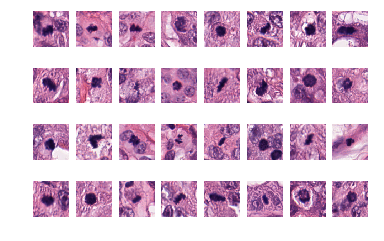

Some negative examples (shape (101, 101, 3)):


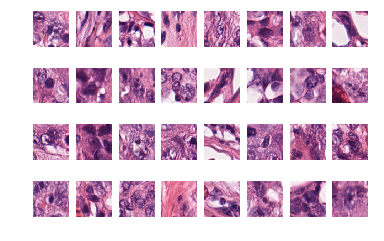

In [5]:
# Collect paths for all images (positive and negative training, and test images)
training_positives_paths = glob(join(data_dir, 'training', 'positive', '*.png'))
training_negatives_paths = glob(join(data_dir, 'training', 'negative', '*.png'))
test_paths = glob(join(data_dir, 'test', '*.png'))

print('Sample positive training path: {path}'.format(path=training_positives_paths[0]))
print('Sample negative training path: {path}'.format(path=training_negatives_paths[0]))
print('Sample test path: {path}'.format(path=test_paths[0]))

print('There are {a} mitotic and {b} non-mitotic training patches'.format(a=len(training_positives_paths), b=len(training_negatives_paths)))
print('There are {a} test patches'.format(a=len(test_paths)))

# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    image = image/255
    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

# Read a few example images and plot them
images_positive = [load_image(path) for path in training_positives_paths[:32]]
images_negative = [load_image(path) for path in training_negatives_paths[:32]]

print('Some positives examples (shape {shape}):'.format(shape=images_positive[0].shape))
plot_image(images_positive, images_per_row=8)

print('Some negative examples (shape {shape}):'.format(shape=images_negative[0].shape))
plot_image(images_negative, images_per_row=8)

### Parsing Filenames

Assignment 8 got the following meta-data from the file names but only used **patient case** and **label**:
* Score (ignore for this assignment): 0.000655216630548
* Patient case: 08
* Tile ID: 06
* Stain standardization status: Normalized
* X-location: 1635
* Y-location: 1047
* Label (mitotic 1, non-mitotic 0): 1

Also the test patches did not have the score or label.

In [6]:
# Extract meta-data from a sample patch path in a dictionary format.
def parse_file_name(file_path, test=False):
    
    # Training sample: 0.9620013237_02_27_Normalized_1175_78_1.png
    # Test sample: 01_01_Normalized_1001_856.png
    filename = basename(file_path)
    splitFileName = filename.replace('.png','').split("_")
    
    if not test:
        score = splitFileName[0] #Score (not used this assignment)
        case = splitFileName[1]  #Patient case
        tile = splitFileName[2]  #Tile ID
        _ = splitFileName[3]     #Stain standardisation status
        x = splitFileName[4]     #X-Location
        y = splitFileName[5]     #Y-Location
        label = splitFileName[6] #Label (mimotic 1, non-mimotic 0)
    else:
        case = splitFileName[0]  #Patient case
        tile = splitFileName[1]  #Tile ID
        _ = splitFileName[2]     #Stain standardisation status
        x = splitFileName[3]     #X-Location
        y = splitFileName[4]     #Y-Location
        score = np.nan
        label = -1
    
    data = {
        'case': int(case),
        'label': int(label),
        'file_id': filename
    }
    
    return data

info1 = parse_file_name(training_positives_paths[0], test=False)
print('The following information is available for patch path {path}:'.format(path=training_positives_paths[0]))
print(info1)

info2 = parse_file_name(test_paths[0], test=True)
print('The following information is available for patch path {path}:'.format(path=test_paths[0]))
print(info2)

The following information is available for patch path /projects/0/ismi2018/AMIDA13/training/positive/0.997251331806_04_40_Normalized_1292_1346_1.png:
{'case': 4, 'label': 1, 'file_id': '0.997251331806_04_40_Normalized_1292_1346_1.png'}
The following information is available for patch path /projects/0/ismi2018/AMIDA13/test/01_23_Normalized_558_119.png:
{'case': 1, 'label': -1, 'file_id': '01_23_Normalized_558_119.png'}


### Create a Pandas Dataframe

The data of assignment 8 consisted of two (main) folders, training and test, containing RGB 101x101 pixel image patches. 
Here we divide the training set into actual training and validation sets to control overfitting during training. 
Pandas' dataframes are tables with columns for all attributes (label, case, filename, etc.) and a row for each sample.
Panda tutorials: https://pandas.pydata.org/pandas-docs/stable/tutorials.html

The code below gives a small overview of basic functions of a Pandas' data frame.

In [7]:
# Example
data_dict = [
    {'a': 1, 'b': 1, 'c': 2},
    {'a': 0, 'b': 4, 'c': 1},    
    {'a': 0, 'b': 4}
]

print('My dataframe looks like:')
df = pd.DataFrame(data_dict)
print(df)

print('Columns or rows can be selected with loc[] and iloc[]:')
print('Col "b":')
col = df.loc[:, 'b']  # ":" means "select all items"
print(col)
print('Row 1:')
row = df.iloc[1, :]
print(row)

print('Conditional selection can be also done with loc[]:')
print('Show columns "a" and "b" of elements where column "b" is 4:')
sel = df.loc[df['b']==4, ['a', 'b']]
print(sel)

My dataframe looks like:
   a  b    c
0  1  1  2.0
1  0  4  1.0
2  0  4  NaN
Columns or rows can be selected with loc[] and iloc[]:
Col "b":
0    1
1    4
2    4
Name: b, dtype: int64
Row 1:
a    0.0
b    4.0
c    1.0
Name: 1, dtype: float64
Conditional selection can be also done with loc[]:
Show columns "a" and "b" of elements where column "b" is 4:
   a  b
1  0  4
2  0  4


In [8]:
# Get lists of image paths (we use "all" to refer to training+validation data)
all_paths = glob(join(data_dir, 'training', '*', '*.png'))
test_paths = glob(join(data_dir, 'test', '*.png'))

# Parse file names into dictionaries
all_data_dicts = [parse_file_name(path) for path in all_paths]
test_data_dicts = [parse_file_name(path, True) for path in test_paths]

# Convert list of dictionaries to Pandas dataframe
df_all_data = pd.DataFrame(all_data_dicts)
df_test_data = pd.DataFrame(test_data_dicts)


# Explore dataframe
print('There are {a} mitotic and {b} non-mitotic training patches'.format(
    a=len(df_all_data.loc[df_all_data['label']==1, :]), 
    b=len(df_all_data.loc[df_all_data['label']==0, :])
))
print('There are {a} test patches'.format(a=len(df_test_data)))
df_all_data

There are 319 mitotic and 27325 non-mitotic training patches
There are 13201 test patches


,case,file_id,label
0,4,0.000187920784811_04_33_Normalized_787_106_0.png,0
1,8,0.00043399783317_08_05_Normalized_1727_368_0.png,0
2,2,3.32185009029e-05_02_08_Normalized_253_1476_0.png,0
3,4,0.286213368177_04_52_Normalized_1574_259_0.png,0
4,7,2.99796647596e-06_07_20_Normalized_883_662_0.png,0
5,2,0.000346281361999_02_02_Normalized_910_1626_0.png,0
6,4,1.04035370896e-05_04_33_Normalized_978_1578_0.png,0
7,12,1.968813649e-06_12_06_Normalized_464_1713_0.png,0
8,4,0.0138526586816_04_48_Normalized_550_1217_0.png,0
9,4,0.00102501106448_04_35_Normalized_970_720_0.png,0


### Split Data into Training, Validation and Test.

Here we use Panda to divide the dataset into training, validation and test according to patient case, and store the resulting dataframes into disk (as .csv file).

In [9]:
# Set patient case
training_cases = [8, 4, 12, 5, 7] 
validation_cases = [9, 3, 2] 

# Shuffle all data
df_all_data = df_all_data.sample(len(df_all_data), replace=False).reset_index(drop=True)

# Select rows whose 'case' column is among the training list
idx_rows_within_training = df_all_data['case'].isin(training_cases)
# Create a dataframe that consists of only the training cases (Hint: can be done with a single line using Pandas)
df_training_data = df_all_data.loc[idx_rows_within_training]
#df_training_data = pd.DataFrame(df_all_data, index = training_cases)

# Select rows whose 'case' column is among the validation list
idxs_rows_within_validation = df_all_data['case'].isin(validation_cases)
# Create a dataframe that consists of only the validation cases (Hint: can be done with a single line using Pandas)
df_validation_data = df_all_data.loc[idxs_rows_within_validation]
#df_validation_data = pd.DataFrame(df_all_data, validation_cases)

# Store file names into disk
df_training_data.to_csv(join(result_dir, 'training_data.csv'))
df_validation_data.to_csv(join(result_dir, 'validation_data.csv'))
df_test_data.to_csv(join(result_dir, 'test_data.csv'))

# Load CSV data from disk (to check that saving works)
df_training_data = pd.DataFrame.from_csv(join(result_dir, 'training_data.csv'), header=0, index_col=0)
df_validation_data = pd.DataFrame.from_csv(join(result_dir, 'validation_data.csv'), header=0, index_col=0)
df_test_data = pd.DataFrame.from_csv(join(result_dir, 'test_data.csv'), header=0, index_col=0)

# Verify that training dataframe contains training cases only (same for validation and test dataframes)
unique_cases_in_training = df_training_data['case'].unique()
print('Cases present in the training dataframe: {cases}'.format(cases=unique_cases_in_training))
unique_cases_in_validation = df_validation_data['case'].unique()
print('Cases present in the validation dataframe: {cases}'.format(cases=unique_cases_in_validation))
unique_cases_in_test = df_test_data['case'].unique()
print('Cases present in the test dataframe: {cases}'.format(cases=unique_cases_in_test))

Cases present in the training dataframe: [ 5  4  7 12  8]
Cases present in the validation dataframe: [2 3 9]
Cases present in the test dataframe: [ 1  6 11 10]


## Data Handlers 

Here we manage data using Keras [generators](https://keras.io/models/model/#fit_generator). 

### Data Generator

[generators](https://wiki.python.org/moin/Generators) provide us with ready-to-use training batches. Generators return a new random batch when calling `next()`.

PatchGenerator detected: 19157 patch samples.


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


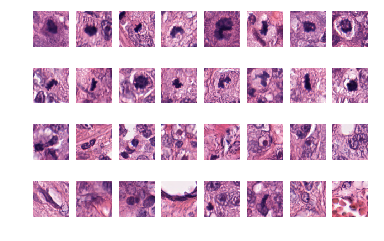

In [10]:
class PatchGenerator(object):
    
    def __init__(self, input_dir, csv_path, batch_size, augmentation_fn=None):
        
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.csv_path = csv_path  # path to CSV with data split
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.batch_size
        
        # Print some info
        print('PatchGenerator detected: {n_samples} patch samples.'.format(n_samples=self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        
        # Randomly sample positive samples from the dataframe 
        # Tip: self.df.loc[self.df['label'] == 1, :].sample(...)
        df_positives = self.df.loc[self.df['label'] == 1, :].sample(round(self.batch_size/2))
        
        # Randomly sample negative samples from the dataframe
        df_negatives =  self.df.loc[self.df['label'] == 0, :].sample(round(self.batch_size/2))
        
        # Concatenate positive and negative sample dataframes
        df_batch = pd.concat([df_positives, df_negatives])

        # Iterate over selected images 
        images = []
        labels = []
        for index, row in df_batch.iterrows():
            
            try:

                # Read image path
                image_path = glob(join(self.input_dir, row['file_id']))
                assert len(image_path) == 1
                image_path = image_path[0]

                # Read data and label
                image = load_image(image_path)
                label = row['label']

                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                images.append(image)
                labels.append((1-label, label))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx=index))

        # Assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y
    
# Test the data generator
training_gen = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

### Data Sequence

A Keras Sequence is a 'generator' for validation data. Sequences always read the same data in the same order (generators read the patches randomly). Other differences: 
* no augmentation.
* mini-batches are not balanced.

**WARNING:  the last mini-batch might be smaller that batch size!**

PatchSequence detected: 8487 patch samples.


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


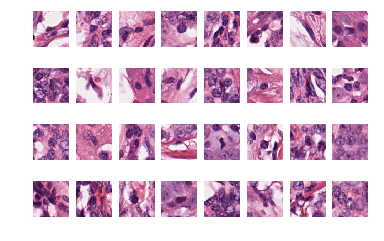

In [11]:
class PatchSequence(keras.utils.Sequence):

    def __init__(self, input_dir, csv_path, batch_size):

        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.csv_path = csv_path  # path to CSV with data split
        self.batch_size = batch_size  # number of patches per batch
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Length
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('PatchSequence detected: {n_samples} patch samples.'.format(n_samples=len(self.df)))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def get_all_labels(self):
        return self.df.loc[:, 'label'].values
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        labels = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                # Read image path
                row = self.df.iloc[i, :]
                image_path = glob(join(self.input_dir, row['file_id']))
                assert len(image_path) == 1
                image_path = image_path[0]

                # Read data and label
                image = load_image(image_path)
                label = row['label']
 

                # Append
                images.append(image)
                labels.append((1-label, label))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx=i))

        # Assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y

# Test the sequence
validation_seq = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'validation_data.csv'), 
    batch_size=32
)

for batch_x, batch_y in validation_seq:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

### Data Augmentation

Basic data augmentation (vertical and horizontal mirroring, and 90-degree rotation). 

PatchGenerator detected: 19157 patch samples.


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


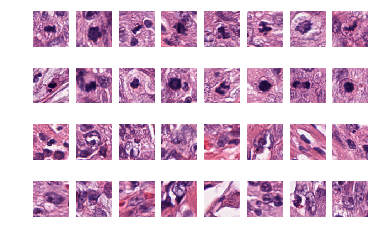

In [12]:
def basic_augmentation(image_array):
    
    # Vertical mirroring
    if np.random.rand() > 0.5:
        image_array = np.flipud(image_array)

    # Horizontal mirroring
    if np.random.rand() > 0.5:
        image_array = np.fliplr(image_array)

    # 90-degree rotation
    if np.random.rand() > 0.5:
        image_array = np.rot90(image_array)
    
    return image_array

# Test basic augmentation
training_gen = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32,
    augmentation_fn=basic_augmentation
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

## Network Training

### Network Architecture

Binary classification model.

In [13]:
def  build_model():

    tensor_input = keras.Input(shape=(101,101,3))
    flattened = keras.layers.Flatten()(tensor_input)
    
    tensor = keras.layers.Dense(32, kernel_initializer='normal', activation='relu')(flattened)
    tensor = keras.layers.BatchNormalization()(tensor) #ROBIN SUGGESTION. maybe after each layer?
    tensor = keras.layers.Dense(64, kernel_initializer='normal', activation='relu')(tensor)
    tensor = keras.layers.Dense(128, kernel_initializer='normal', activation='relu')(tensor)
    tensor = keras.layers.Dense(256, kernel_initializer='normal', activation='relu')(tensor)
    tensor = keras.layers.BatchNormalization()(tensor) #ROBIN SUGGESTION. maybe after each layer?
    tensor = keras.layers.Dropout(0.5)(tensor)
    tensor = keras.layers.Dense(512, kernel_initializer='normal', activation='relu')(tensor)
    tensor = keras.layers.Dense(2, kernel_initializer='uniform', activation='relu')(tensor)

    model = keras.models.Model(inputs=tensor_input, outputs=tensor)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 101, 101, 3)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30603)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                979328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
__________

### Training

Using Keras fit_generator function.

In [14]:
# Training data# Traini 
training_data = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32
)

# Validation data
validation_data = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'validation_data.csv'), 
    batch_size=32
)

# Train model
history = model.fit_generator(training_data, steps_per_epoch=598, epochs=5, validation_data=validation_data )

PatchGenerator detected: 19157 patch samples.
PatchSequence detected: 8487 patch samples.
Epoch 1/5


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


598/598 [==============================] - 322s 539ms/step - loss: 2.3032 - acc: 0.6888 - val_loss: 2.3302 - val_acc: 0.0126
Epoch 2/5
598/598 [==============================] - 223s 374ms/step - loss: 0.2350 - acc: 0.9269 - val_loss: 0.6254 - val_acc: 0.7914
Epoch 3/5
598/598 [==============================] - 217s 363ms/step - loss: 0.1278 - acc: 0.9739 - val_loss: 0.1325 - val_acc: 0.9631
Epoch 4/5
598/598 [==============================] - 213s 357ms/step - loss: 0.1303 - acc: 0.9716 - val_loss: 0.0892 - val_acc: 0.9914
Epoch 5/5
598/598 [==============================] - 208s 348ms/step - loss: 0.0748 - acc: 0.9855 - val_loss: 0.5816 - val_acc: 0.8119


## Training Callbacks

Keras [callbacks](https://keras.io/callbacks/) are used to:
* reduce the learning rate when the validation loss plateaus
* stop training if validation loss does not improve after 5 epochs
* save the best model weights according to the validation loss

In [15]:
# Define simple callbacks
network_path = join(result_dir, 'best_model.h5')
callbacks_list = [
    keras.callbacks.ModelCheckpoint(network_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
]

# Train model
history = model.fit_generator(training_data, steps_per_epoch=599, epochs=5, callbacks=callbacks_list, validation_data=validation_data)

Epoch 1/5


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


599/599 [==============================] - 213s 355ms/step - loss: 0.1143 - acc: 0.9774 - val_loss: 0.1374 - val_acc: 0.9568
Epoch 2/5
599/599 [==============================] - 206s 344ms/step - loss: 0.0829 - acc: 0.9876 - val_loss: 0.1200 - val_acc: 0.9870
Epoch 3/5
599/599 [==============================] - 206s 344ms/step - loss: 0.0781 - acc: 0.9884 - val_loss: 0.0863 - val_acc: 0.9861
Epoch 4/5
599/599 [==============================] - 203s 339ms/step - loss: 0.1311 - acc: 0.9718 - val_loss: 0.0736 - val_acc: 0.9900
Epoch 5/5
599/599 [==============================] - 200s 334ms/step - loss: 0.0913 - acc: 0.9801 - val_loss: 0.2589 - val_acc: 0.9639


### Custom Callback

Generate a plot of the loss and validation loss during training (after each epoch).

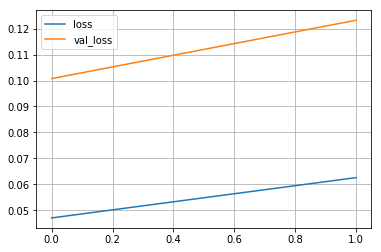

In [16]:
class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.grid()
        plt.legend()
        plt.show();

# Append to list of callbacks
callbacks_list = [
    PlotLosses(),
    keras.callbacks.ModelCheckpoint(network_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
]


# Train model
history = model.fit_generator(training_data, steps_per_epoch=599, epochs=5, callbacks=callbacks_list, validation_data=validation_data)

## Evaluation

Here we:
* define the F1-score function
* plot the [F1-score](https://en.wikipedia.org/wiki/F1_score) curve
* create a callback to evaluate the validation set (after training) and find the best detection threshold 
* create a callback to make predictions on the test set and prepare a submission file

### F1-score function

In [17]:
# Definition of F1-score
# Tip: use precision_recall_curve() to help you compute precision and recall.

def f1_score(y_true, y_pred):
    
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    thresholds = np.append(thresholds, thresholds[-1])
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    thresholds = thresholds[~np.isnan(f1)]
    f1 = f1[~np.isnan(f1)]
    
    return f1, thresholds

### Plot F1-score

In [18]:
def plot_f1_curve(y_true, y_pred, output_path):
    
    # Compute F1-score
    f1, thresholds = f1_score(y_true, y_pred)
    
    # Plot
    tag = 'Max %f @ %f' % (np.max(f1), thresholds[np.argmax(f1)])
    plt.plot(thresholds, f1, label=tag)
    plt.title('F1-score')
    plt.ylim(0.0, 1)
    plt.xlim(0.0, 1)
    plt.grid(b=True, which='both')
    plt.legend(loc='upper left')
    plt.savefig(output_path)
    plt.close()

### Evaluation of Validation Set

Here we automatically select the optimal detection threshold (maximize the F1-score) using a callback that:
* Loads the best model from disk
* Loads the validation set as a Sequence
* Runs the model over the validation samples
* Gets labels from validation set
* Computes the F1-score
* Saves the F1-score curve plot to disk
* Saves the best detection threshold to disk

In [19]:
class FindBestDetectionThreshold(keras.callbacks.Callback):

    def __init__(self, data_dir, csv_dir, result_dir):
        self.data_dir = data_dir
        self.csv_dir = csv_dir
        self.result_dir = result_dir
        super(FindBestDetectionThreshold, self).__init__()

    def on_train_end(self, epoch, logs=None):
        
        print('Evaluating validation set ...')
        
        # Load best model
        model_path = join(self.result_dir, 'best_model.h5')
        best_model = keras.models.load_model(model_path)
        
        # Load validation set as a sequence
        validation_seq = PatchSequence(
            input_dir=join(self.data_dir, 'training', '*'), 
            csv_path=join(self.csv_dir, 'validation_data.csv'), 
            batch_size=32
        )
        
        # Run the model over samples
        y_pred = self.model.predict_generator(validation_seq)[:, 1]
        
        # Get labels
        y_true = validation_seq.get_all_labels()
        
        # Compute F1-score
        f1, thresholds = f1_score(y_true, y_pred)
        
        # Save F1-score curve
        plot_f1_curve(y_true, y_pred, join(self.result_dir, 'f1-score_validation.png'))

        # Save best detection threshold
        th = {'threshold': thresholds[np.argmax(f1)], 'f1': f1[np.argmax(f1)]}
        pd.DataFrame(th, index=[0]).to_csv(join(self.result_dir, 'best_threshold.csv'))

### Evaluation of Test Set

Here we create the .csv for https://ismi-amida13.grand-challenge.org/ using a callback that:
* Loads the best model from disk
* Loads the test set as a Sequence
* Runs the model over the test samples
* Reads best threshold file
* Threshold predictions
* Store the predictions in a suitable CSV for the submission

In [20]:
class CreateFinalSubmission(keras.callbacks.Callback):

    def __init__(self, data_dir, csv_dir, result_dir):
        self.data_dir = data_dir
        self.csv_dir = csv_dir
        self.result_dir = result_dir
        super(CreateFinalSubmission, self).__init__()

    def on_train_end(self, epoch, logs=None):
        
        print('Evaluating test set ...')

        # Load best model
        model_path = join(self.result_dir, 'best_model.h5')
        best_model = keras.models.load_model(model_path)
        
        # Load test set as a sequence
        test_seq = PatchSequence(
            input_dir=join(self.data_dir, 'test'), 
            csv_path=join(self.csv_dir, 'test_data.csv'), 
            batch_size=32
        )
        
        # Run the model over samples
        y_pred = self.model.predict_generator(test_seq)[:, 1]
        
        # Read best threshold
        df_th = pd.DataFrame.from_csv(join(self.result_dir, 'best_threshold.csv'))
        th = df_th.threshold
        print(th)
        
        # Threshold predictions TODO hier moet nog iets. Even koppen bij elkaar?
        y_pred_bin = y_pred #y_pred >= th <-- iets als dit.. 

        # Make CSV
        df = test_seq.df
        df['label'] = y_pred_bin
        df['file_id'] = df['file_id'].apply(lambda x: x[:-4])
        df = df.loc[:, ['label', 'file_id']]
        df.to_csv(join(self.result_dir, 'submission.csv'), index=None)

## Train a classifier

Here we create a function to train a model by:
* Defining the training generator with augmentation
* Defining the validation sequence
* Building the model
* Defining simple and advanced callbacks (in particular: evaluation of validation and test sets)
* Training the model using fit_generator

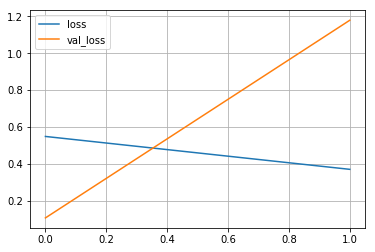

Evaluating validation set ...
PatchSequence detected: 8487 patch samples.


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Evaluating test set ...
PatchSequence detected: 13201 patch samples.
0    47.870583
Name: threshold, dtype: float64


In [21]:
def train_model(data_dir, csv_dir, result_dir, training_csv, validation_csv, batch_size=32, epochs=10, augmentation_fn=None, debug=False):
    
    # Prepare dir
    if not exists(result_dir):
        os.mkdir(result_dir)
    
    # Training data
    training_data = PatchGenerator(
        input_dir=join(data_dir, 'training', '*'), 
        csv_path=join(csv_dir, training_csv), 
        batch_size=batch_size,
        augmentation_fn=augmentation_fn
    )

    # Validation data
    validation_data = PatchSequence(
        input_dir=join(data_dir, 'training', '*'), 
        csv_path=join(csv_dir, validation_csv), 
        batch_size=batch_size
    )
        
    # Build model
    model = build_model()
    model.summary
    
    # Define callbacks
    callbacks_list = [
        PlotLosses(),
        FindBestDetectionThreshold(data_dir=data_dir, csv_dir=csv_dir, result_dir=result_dir),
        CreateFinalSubmission(data_dir=data_dir, csv_dir=csv_dir, result_dir=result_dir),
        keras.callbacks.ModelCheckpoint(network_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1),
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    ]

    # Train model
    history = model.fit_generator(training_data, steps_per_epoch=598, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_data=validation_data)
    
# Train the first model
train_model(
    data_dir=data_dir, 
    csv_dir=result_dir,
    result_dir=result_dir,
    training_csv='training_data.csv',
    validation_csv='validation_data.csv', 
    batch_size=32, 
    epochs=10, 
    augmentation_fn=basic_augmentation, 
    debug=True
)

# Remember to submit the results (manually)

## Hard negative mining

By training a CNN to perform a discriminative task, we are effectively building a decision boundary (hyper-plane) to separate mitotic from non-mitotic patches. Each training sample pushes and changes the shape of this decision boundary so that more and more difficult samples are correctly classified.

When the training dataset contains only very easy 'negative samples' (that look nothing like the 'positive' ones) we wont be able to detect difficult samples. 

Here we will include more difficult samples in the training set by defining the difficulty of a sample based on the prediction score produced by the initial model (Very low probability means it's an easy sample, higher probability means its harder).

### Compute scores for test set

Here we compute a prediction score for each training sample and store it in a Panda dataframe.

In [22]:

# Read the training set as a sequence# Read  
training_seq = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'),
    batch_size=32
)
#model_path = join(result_dir, 'initial', 'best_model.h5')

# Load the initial mode
model_path = join(result_dir, 'initial', 'best_model.h5')
initial_model = keras.models.load_model(model_path)

# Predict
y_train_pred = initial_model.predict_generator(None)

# Store in dataframe
df_training_data = pd.DataFrame.from_csv(join(result_dir, 'training_data.csv'))
df_training_data['pred'] = None
df_training_data

PatchSequence detected: 19157 patch samples.


AttributeError: 'NoneType' object has no attribute 'predict_generator'

### Resample the training set

Here we create a new training .csv dataset based on the prediction scores.

In [ ]:
# Select all positive samples# Selec 
df_training_positives = None

# Select all negative samples
df_training_negatives = None

# Resample negative samples proportionally to their scores
df_training_hard_negatives = df_training_negatives.sample(None)

# Concatenate positives and hard negative samples
df_hard_training_data = pd.concat([df_training_positives, df_training_hard_negatives])

# Store CSV on disk
df_hard_training_data.to_csv(join(result_dir, 'difficult_training_data.csv'))

Plot histograms of scores before and after sampling and make sure there are more difficult samples in the second set.

In [ ]:
df_training_data.loc[df_training_data['label'] == 0, :].hist('pred')
plt.show()
df_hard_training_data.loc[df_hard_training_data['label'] == 0, :].hist('pred')
plt.show()

## Retrain the Classifier

Here we retrain the model with the new dataset. 

In [ ]:
# Train the second model
train_model(
    data_dir=data_dir, 
    csv_dir=result_dir,
    result_dir=result_dir,
    training_csv='difficult_training_data.csv',
    validation_csv='validation_data.csv', 
    batch_size=32, 
    epochs=10, 
    augmentation_fn=basic_augmentation, 
    debug=True
)

# Remember to submit the results (manually)